In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
from lin_reg import best_line

### Table of Contents

1. Business Understanding
2. Data Understanding
3. Data Preparation
    - 3.i. TMDB data
    - 3.ii. The numbers data
        - 3.ii.a. Removing zeroes
        - 3.ii.b Keeping Only Post-2000 Data (Inclusive)
        - 3.ii.c. Creating an ROI column
        - 3.ii.d. Removing Budget Outliers
    - 3.iii. SQL IMDB Database
        - 3.iii.a Creating Directors and Writers DataFrames
    - 3.iv. Getting DataFrames for Runtime and Budget Regressions
    - 3.v. Creating DataFrames for 2-D and 3-D Movies
4. Data Analysis
    - 4.i Release Month Analysis
    - 4.ii 3-D vs. 2-D Analysis
    - 4.ii.a 2-Sample T-Tests on 2-D vs. 3-D
    - 4.iii. Experienced vs. Inexperienced Directors and Writers Analysis
        - Directors hypothesis test
        - Writers hypothesis test
    - 4.iv. Runtime and Budget Analysis
        - Budget Regressions and Visuals
        - Runtime Regressions and Visuals


# (1) Business Understanding 

# (2) Data Understanding

In [3]:
# Importing our datasets

tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz')
conn = sqlite3.connect('data/im.db')

# (3) Data Preparation

## (3.i) TMDB Data

This data comes from The Movie Database (TMDB), which can be accessed [here](https://www.themoviedb.org/?language=en-US).

We can first check out our `tmdb_movies` data using a `.info()` and `.head()`. We can see that we have 26,517 rows to start, with 9 columns of data and an index column. We have some basic information about the film -- notably the name and release date -- as well as some metrics relating to popularity: `popularity`, `vote_average`, `vote_count`. 

In [4]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


We'll then do some basic data cleaning. We're eventually going to merge with a few other dataframes using the name of the film, so we're going to preemptively change the `title` column to be named `primary_title`. We'll also drop those columns of data which are unnecessary for our analysis. As we would expect, we still have our 26,517 records.

In [5]:
# Rename the title column to primary_title to match the other dataframes
tmdb_movies.rename(columns={'title': 'primary_title'}, inplace=True)
# Drop the columns that are not needed
tmdb_movies.drop(columns=['genre_ids', 'original_language', 'original_title'], inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26517 non-null  int64  
 1   id             26517 non-null  int64  
 2   popularity     26517 non-null  float64
 3   release_date   26517 non-null  object 
 4   primary_title  26517 non-null  object 
 5   vote_average   26517 non-null  float64
 6   vote_count     26517 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


## (3.ii) The Numbers Data
Our next dataset comes from The Numbers, which can be found [here](https://www.the-numbers.com/movie/budgets/all). 

We'll once again start off with a `.info()` and `.head()` so that we can get a sense of what's contained in the data. Here, we get some of our financial information. Specifically, we can see the reported `production_budget` of the movie, along with its `domestic_gross` and `worldwide_gross`. From here, we'll be able to compute a rudimentary (if somewhat flawed) return on investment (ROI) figure. 

In [6]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We can also see that the `movie` column corresponds to the name of the film, so we will once again rename that column to `primary_title` so that we can perform merges later. Additionally, the financial columns are formatted as strings rather than integers. We will first strip the dollar signs and commas out of the string and then convert the columns to the integer datatype, so that we can more easily perform our analyses. We also will convert `release_date` to a `datetime` object, and from there extract both the month and year of release, and create the corresponding columns `release_month` and `release_year`.

In [8]:
# Rename the movie column to primary_title to match the other dataframes
tn_movie_budgets.rename(columns={'movie': 'primary_title'}, inplace=True)
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [9]:
# Convert the release_date column to a datetime object and create new columns for release_month and release_year
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_month'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.month_name()
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

In [10]:
# Create a function to allow us to convert the columns to integers
def convert_to_int(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '').astype(int)
    return df[column]

# Call the function for our three columns
convert_to_int(tn_movie_budgets, 'domestic_gross')
convert_to_int(tn_movie_budgets, 'worldwide_gross')
convert_to_int(tn_movie_budgets, 'production_budget')

# Check to make sure everything looks alright
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 361.5+ KB


In [11]:
# We'll also order our months chronologically, so when we plot them, the x
# Axis won't be in alphabetical order.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tn_movie_budgets['release_month'] = pd.Categorical(tn_movie_budgets['release_month'], categories=months, ordered=True)
tn_movie_budgets['release_month'].value_counts()

December     745
October      573
August       496
September    493
November     486
June         479
March        470
April        454
July         440
May          407
February     392
January      347
Name: release_month, dtype: int64

### (3.ii.a) Removing zeroes

Within this dataset, we have a number of films for which there is no reported budget data. Since one of our chief concerns is the financial success of a film, the lack of data on these fronts makes those records useless. 

We first check to make sure that removing the data for which we have no budget information does not throw out an excessive number of records. We go from 5,782 entries to 5,234, so it seems pretty safe to remove the zeroes.

In [12]:
tn_movie_budgets.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,release_month,release_year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,December,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,May,2011
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,June,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,May,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,December,2017


In [13]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 322.4+ KB


In [14]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [15]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548 entries, 194 to 5780
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 548 non-null    int64         
 1   release_date       548 non-null    datetime64[ns]
 2   primary_title      548 non-null    object        
 3   production_budget  548 non-null    int64         
 4   domestic_gross     548 non-null    int64         
 5   worldwide_gross    548 non-null    int64         
 6   release_month      548 non-null    category      
 7   release_year       548 non-null    int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 35.2+ KB


In [16]:
# Since we wouldn't lose too much data, we can drop the zeroes
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0]

In [17]:
tn_movie_budgets['domestic_gross'].isna().sum()

0

In [18]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


In [19]:
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].astype(int)

In [20]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 0 non-null      int64         
 1   release_date       0 non-null      datetime64[ns]
 2   primary_title      0 non-null      object        
 3   production_budget  0 non-null      int64         
 4   domestic_gross     0 non-null      int64         
 5   worldwide_gross    0 non-null      int64         
 6   release_month      0 non-null      category      
 7   release_year       0 non-null      int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 416.0+ bytes


One potentially problematic point is the spread of data for the `release_year`. Just from a preliminary look, we can see that there are a handful of films from the very early days of cinema. Since these will likely not have huge bearing on a start-up production company today, and since they constitute a very small proportion of our data, we can go ahead and filter them out. 

Below, you can see the distribution and count for our full dataset. We go from 5234 entries to 3865 entries.

In [21]:
tn_movie_budgets['release_year'].value_counts().sort_index()

1915      1
1916      1
1920      1
1925      2
1929      1
       ... 
2015    208
2016    192
2017    149
2018    137
2019     44
Name: release_year, Length: 92, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 332.6+ KB


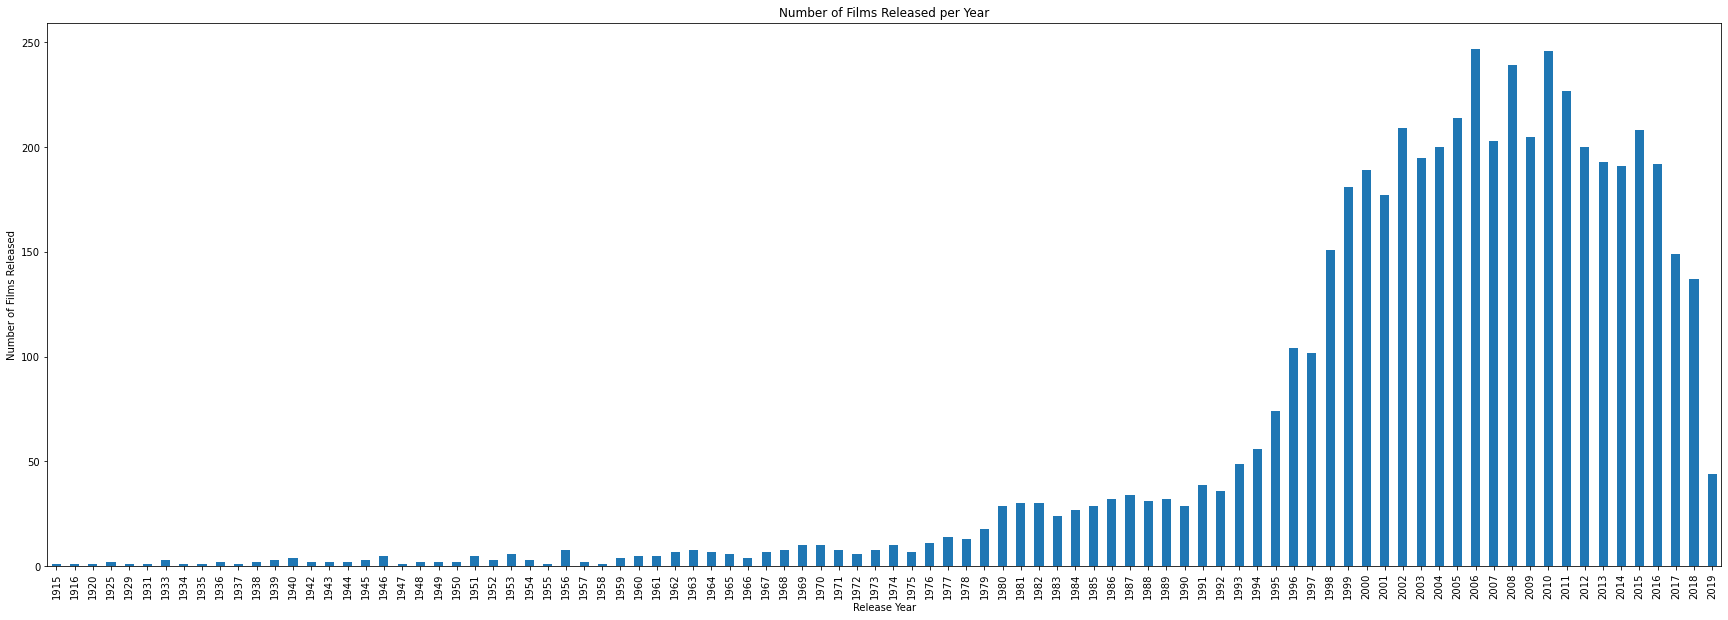

In [22]:
ax1 = plt.subplots(figsize = (30, 10))

ax1 = tn_movie_budgets['release_year'].value_counts().sort_index().plot.bar()
ax1.set_title('Number of Films Released per Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Films Released')

plt.style.use('ggplot')
tn_movie_budgets.info()


This graph justifies our decision to focus only on data from recent films. As the vast majority of films in this dataset are post-2000, we will subset to this period.

### (3.ii.b) Keeping Only Post-2000 Data (Inclusive)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 245.7+ KB


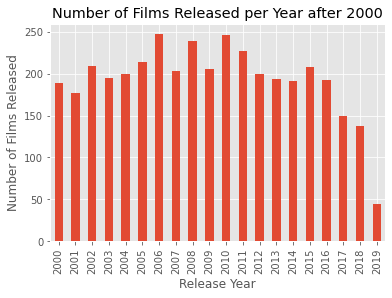

In [23]:
tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()

ax2 = tn_2000['release_year'].value_counts().sort_index().plot.bar()
ax2.set_title('Number of Films Released per Year after 2000')
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Number of Films Released')


plt.style.use('ggplot')
tn_2000.info()

In [24]:
# Saving the year filter in place
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 245.7+ KB


### (3.ii.c) Creating an ROI Column

In [25]:
tn_movie_budgets['domestic_ROI'] = ((tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

tn_movie_budgets['worldwide_ROI'] = ((tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

In [26]:
tn_movie_budgets.isna().sum()

id                   0
release_date         0
primary_title        0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_month        0
release_year         0
domestic_ROI         0
worldwide_ROI        0
dtype: int64

In [27]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
 8   domestic_ROI       3865 non-null   float64       
 9   worldwide_ROI      3865 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 306.1+ KB


In [28]:
# Since there are very few nulls relative to all the domestic_gross data points, we drop them here
tn_movie_budgets.dropna(subset = ['domestic_gross'], inplace=True)

In [29]:
tn_movie_budgets.isna().sum()

id                   0
release_date         0
primary_title        0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_month        0
release_year         0
domestic_ROI         0
worldwide_ROI        0
dtype: int64

### (3.ii.d) Removing Budget Outliers

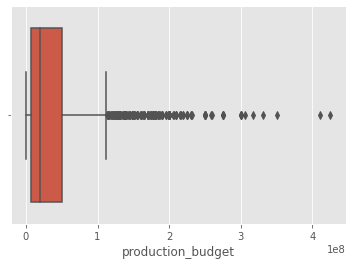

In [30]:
#Boxplot to visualize the outliers
sns.boxplot(x=tn_movie_budgets['production_budget'])
plt.show()

In [31]:
# Calculating the first and third quartiles for production budget
Q1 = tn_movie_budgets['production_budget'].quantile(0.25)
Q3 = tn_movie_budgets['production_budget'].quantile(0.75)

# Calculating the Interquartile Range
IQR = Q3 - Q1

# Getting the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing the rows with production budget outliers, saving as a separate df
tn_movie_budgets_no_outliers= tn_movie_budgets.loc[(tn_movie_budgets['production_budget'] >= lower_bound) & (tn_movie_budgets['production_budget'] <= upper_bound)]


## (3.iii) SQL IMDB Database

In [32]:
# Viewing the schema
pd.read_sql('SELECT name AS "Table Names" FROM sqlite_master WHERE type="table"', conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [33]:
# Making the movie_basics table into a DataFrame
imdb_movie_basics = pd.read_sql('SELECT * FROM movie_basics', conn)
imdb_movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [34]:
# Making the movie_akas table into a DataFrame
imdb_movie_akas = pd.read_sql('SELECT * FROM movie_akas', conn)
imdb_movie_akas.drop(columns=['is_original_title'], inplace=True)
imdb_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes
0,tt0369610,10,Джурасик свят,BG,bg,None,None
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None


In [35]:
#Renaming 'movie' column to 'primary_title' so I can join table with 'tn_movie_budgets' table
imdb_movie_akas = imdb_movie_akas.rename(columns={"title": "primary_title"})

In [36]:
imdb_movie_akas['attributes'].isna().sum()

316778

In [37]:
imdb_movie_akas = imdb_movie_akas.dropna(subset=['attributes'])

In [38]:
imdb_movie_akas['attributes'].isna().sum()

0

### (3.iii.a) Creating Directors and Writers DataFrames

In [39]:
# Exploring how many individual directors are in the IMDB directors table
imdb_directors = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM directors;
    """, conn)
imdb_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109253 entries, 0 to 109252
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  109253 non-null  object
dtypes: object(1)
memory usage: 853.7+ KB


In [40]:
# Exploring how many individual writers are in the IMDB writers table
imdb_writers = pd.read_sql(
    """SELECT DISTINCT person_id
    FROM writers;
    """, conn)
imdb_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122576 entries, 0 to 122575
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  122576 non-null  object
dtypes: object(1)
memory usage: 957.8+ KB


In [41]:
# DataFrame for inexperienced directors
d_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() <=3) AS d_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,39566.000000,39566.000000,39566,39566
unique,NaN,NaN,39566,34106
top,NaN,NaN,nm3979464,"Milano 55,1. Cronaca di una settimana di passioni"
freq,NaN,NaN,1,48
mean,6.515766,909.214224,NaN,NaN
std,1.491461,9040.204720,NaN,NaN
min,1.000000,5.000000,NaN,NaN
25%,5.600000,11.000000,NaN,NaN
50%,6.700000,29.000000,NaN,NaN
75%,7.600000,134.000000,NaN,NaN


In [42]:
# DataFrame for experienced directors
d_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, d_n_e.person_id, b.primary_title
FROM movie_ratings AS m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM directors
        GROUP BY person_id
        HAVING COUNT() >3) AS d_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
d_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,12765.000000,1.276500e+04,12765,12765
unique,NaN,NaN,12765,10020
top,NaN,NaN,nm5321221,World of Death
freq,NaN,NaN,1,83
mean,6.159976,5.892464e+03,NaN,NaN
std,1.389006,3.771988e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,2.100000e+01,NaN,NaN
50%,6.300000,8.500000e+01,NaN,NaN
75%,7.100000,5.080000e+02,NaN,NaN


In [43]:
# DataFrame for inexperienced writers
w_n_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_n_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() <=3) as w_n_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_n_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,63619.000000,6.361900e+04,63619,63619
unique,NaN,NaN,63619,40989
top,NaN,NaN,nm0069079,Hug an Atheist
freq,NaN,NaN,1,28
mean,6.274442,3.764226e+03,NaN,NaN
std,1.448698,2.859679e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.400000,1.500000e+01,NaN,NaN
50%,6.400000,5.700000e+01,NaN,NaN
75%,7.300000,3.340000e+02,NaN,NaN


In [44]:
# DataFrame for experienced writers

w_e = pd.read_sql(
"""
SELECT m.averagerating, m.numvotes, w_e.person_id, b.primary_title
FROM movie_ratings as m
    JOIN 
        (SELECT DISTINCT person_id, movie_id
        FROM writers
        GROUP BY person_id
        HAVING COUNT() >3) as w_e
    USING(movie_id)
    JOIN movie_basics AS b
    USING(movie_id)
""", conn)
w_e.describe(include='all')

,averagerating,numvotes,person_id,primary_title
count,8434.000000,8.434000e+03,8434,8434
unique,NaN,NaN,8434,5387
top,NaN,NaN,nm5321221,World of Death
freq,NaN,NaN,1,46
mean,6.101672,9.022202e+03,NaN,NaN
std,1.395730,5.134912e+04,NaN,NaN
min,1.000000,5.000000e+00,NaN,NaN
25%,5.300000,2.100000e+01,NaN,NaN
50%,6.200000,9.700000e+01,NaN,NaN
75%,7.100000,6.335000e+02,NaN,NaN


In [45]:
# Merging the experienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_e = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_d_e = pd.merge(merged_d_e, tn_movie_budgets, on='primary_title')
merged_d_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,7.6,326657,nm0587955,Moneyball,2505,60308,15.393,2011-09-22,7.1,2255,15,2011-09-23,50000000,75605492,111300835,September,2011,51.210984,122.601670
1,7.0,85839,nm2648685,Another Earth,2633,55420,10.030,2011-07-22,6.7,853,48,2011-07-22,175000,1321194,2102779,July,2011,654.968000,1101.588000
2,4.7,59914,nm0001774,Zoolander 2,17483,329833,12.997,2016-02-12,4.7,1374,64,2016-02-12,50000000,28848693,55348693,February,2016,-42.302614,10.697386
3,7.2,28994,nm0000776,Chasing Mavericks,5517,82684,6.546,2012-10-26,7.0,329,67,2012-10-26,20000000,6002756,8300821,October,2012,-69.986220,-58.495895
4,5.7,9089,nm0015328,Jumping the Broom,2704,57119,8.477,2011-05-06,6.0,103,93,2011-05-06,7000000,37295394,38158601,May,2011,432.791343,445.122871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,4.4,5648,nm2411665,Khiladi 786,6157,147767,1.824,2012-12-07,4.7,16,12,2012-12-07,5600000,385422,14683763,December,2012,-93.117464,162.210054
627,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,173897,0.844,2017-01-27,5.9,1859,84,2017-01-27,40000000,26844692,314101190,January,2017,-32.888270,685.252975
628,7.0,163279,nm0197855,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018,86.970449,217.238065
629,7.0,163279,nm0326246,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018,86.970449,217.238065


In [46]:
# Merging the inexperienced directors DataFrame with tmdb_movies and tn.movie_budgets
merged_d_n_e = pd.merge(d_n_e, tmdb_movies, on='primary_title')
merged_d_n_e = pd.merge(merged_d_n_e, tn_movie_budgets, on='primary_title')
merged_d_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,7.0,1613,nm1464150,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
1,6.5,13,nm4418339,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
2,4.4,69199,nm0455078,Sex and the City 2,137,37786,9.986,2010-05-27,5.9,809,16,2010-05-27,95000000,95347692,294680778,May,2010,0.365992,210.190293
3,5.6,44490,nm2552536,Don't Be Afraid of the Dark,214,46261,8.405,2010-11-06,5.5,550,43,2011-08-26,25000000,24046682,39126427,August,2011,-3.813272,56.505708
4,7.1,129443,nm0002339,Remember Me,92,23169,11.453,2010-03-12,7.1,2079,51,2010-03-12,16000000,19068240,56506120,March,2010,19.176500,253.163250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,5.7,37,nm0928316,Sisters,14294,266294,10.993,2015-12-18,5.9,922,57,2015-12-18,30000000,87044645,106030660,December,2015,190.148817,253.435533
847,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014,-99.760364,-99.760364
848,7.7,1165,nm4717106,Phantom,8199,152259,7.211,2013-03-01,6.0,151,43,2013-03-01,18000000,1034589,1199510,March,2013,-94.252283,-93.336056
849,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014,108.838957,108.838957


In [47]:
# Merging the experienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_e = pd.merge(w_e, tmdb_movies, on='primary_title')
merged_w_e = pd.merge(merged_w_e, tn_movie_budgets, on='primary_title')
merged_w_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,8.0,621193,nm1872664,The Revenant,14203,281957,19.410,2015-12-25,7.4,11064,27,2015-12-25,135000000,183637894,532938302,December,2015,36.028070,294.769113
1,8.0,621193,nm1872664,The Revenant,17411,281957,19.410,2015-12-25,7.4,11064,27,2015-12-25,135000000,183637894,532938302,December,2015,36.028070,294.769113
2,7.2,176699,nm0000092,The Croods,7914,49519,16.290,2013-03-22,6.8,3873,26,2013-03-22,135000000,187168425,573068425,March,2013,38.643278,324.495130
3,6.4,6466,nm0119989,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
4,6.4,6466,nm1164861,Freakonomics,401,43942,5.705,2010-10-01,6.6,57,80,2010-10-01,2900000,101270,172867,October,2010,-96.507931,-94.039069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,4.4,5648,nm5244862,Khiladi 786,6157,147767,1.824,2012-12-07,4.7,16,12,2012-12-07,5600000,385422,14683763,December,2012,-93.117464,162.210054
525,5.6,74979,nm0027271,Resident Evil: The Final Chapter,22654,173897,0.844,2017-01-27,5.9,1859,84,2017-01-27,40000000,26844692,314101190,January,2017,-32.888270,685.252975
526,4.9,632,nm1227232,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014,-99.760364,-99.760364
527,6.2,760,nm0502412,Out of the Blue,10024,281697,0.600,2013-10-01,10.0,1,23,2007-10-19,4600000,728,731767,October,2007,-99.984174,-84.092022


In [48]:
# Merging the inexperienced writers DataFrame with tmdb_movies and tn.movie_budgets
merged_w_n_e = pd.merge(w_n_e, tmdb_movies, on='primary_title')
merged_w_n_e = pd.merge(merged_w_n_e, tn_movie_budgets, on='primary_title')
merged_w_n_e

,averagerating,numvotes,person_id,primary_title,Unnamed: 0,id_x,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI
0,4.2,50352,nm0001317,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
1,4.2,50352,nm0316417,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
2,4.2,50352,nm1048866,The Legend of Hercules,11096,188207,13.754,2014-01-10,4.5,805,42,2014-01-10,70000000,18848538,58953319,January,2014,-73.073517,-15.780973
3,7.0,1613,nm1559624,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
4,7.0,1613,nm1670295,The Hammer,869,74447,1.961,2010-10-26,6.5,16,50,2008-03-21,850000,442638,442638,March,2008,-47.924941,-47.924941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,7.6,3004,nm4830779,Antarctica: A Year on Ice,8901,201132,2.061,2013-09-05,7.2,41,71,2014-11-28,1000000,288757,288757,November,2014,-71.124300,-71.124300
2720,7.0,163279,nm0991423,Game Night,23908,445571,19.459,2018-02-23,6.9,2756,94,2018-02-23,37000000,69179066,117378084,February,2018,86.970449,217.238065
2721,4.9,632,nm2178754,The Sleepwalker,11910,244776,2.659,2014-01-20,4.1,9,2,2014-11-21,1100000,2636,2636,November,2014,-99.760364,-99.760364
2722,6.9,14122,nm0697656,Beyond the Lights,11333,241771,7.717,2014-11-14,7.0,238,16,2014-11-14,7000000,14618727,14618727,November,2014,108.838957,108.838957


## Creating a DataFrame for Runtime and Budget

In [49]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
 8   domestic_ROI       3865 non-null   float64       
 9   worldwide_ROI      3865 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 306.1+ KB


In [50]:
imdb_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [51]:
# Merging the tn_movie_budgets, imdb_movie_basics, and tmdb_movies datasets

movie_basics_budget = pd.merge(tn_movie_budgets, imdb_movie_basics, how ='inner', on='primary_title')
movie_basics_budget = pd.merge(movie_basics_budget, tmdb_movies, how ='inner', on='primary_title')
movie_basics_budget 

,id_x,release_date_x,primary_title,production_budget,domestic_gross,worldwide_gross,release_month,release_year,domestic_ROI,worldwide_ROI,...,original_title,start_year,runtime_minutes,genres,Unnamed: 0,id_y,popularity,release_date_y,vote_average,vote_count
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,December,2009,78.942971,553.257713,...,Abatâ,2011,93.0,Horror,6,19995,26.526,2009-12-18,7.4,18676
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,May,2011,-41.289850,154.667286,...,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2470,1865,30.579,2011-05-20,6.4,8571
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,May,2015,38.840250,324.384139,...,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",14169,99861,44.383,2015-05-01,7.3,13457
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,April,2018,126.271827,582.711400,...,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",23811,299536,80.773,2018-04-27,8.3,13948
4,9,2017-11-17,Justice League,300000000,229024295,655945209,November,2017,-23.658568,118.648403,...,Justice League,2017,120.0,"Action,Adventure,Fantasy",20623,141052,34.953,2017-11-17,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,38,2016-03-18,Krisha,30000,144822,144822,March,2016,382.740000,382.740000,...,Krisha,2015,83.0,Drama,18030,323929,5.288,2016-03-18,6.8,86
3542,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2011,NaN,Drama,10276,359406,0.600,2013-06-21,7.0,1
3543,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2017,83.0,Drama,10276,359406,0.600,2013-06-21,7.0,1
3544,45,2017-01-27,Emily,27000,3547,3547,January,2017,-86.862963,-86.862963,...,Emily,2013,26.0,Documentary,10276,359406,0.600,2013-06-21,7.0,1


In [52]:
movie_basics_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3546 entries, 0 to 3545
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_x               3546 non-null   int64         
 1   release_date_x     3546 non-null   datetime64[ns]
 2   primary_title      3546 non-null   object        
 3   production_budget  3546 non-null   int64         
 4   domestic_gross     3546 non-null   int64         
 5   worldwide_gross    3546 non-null   int64         
 6   release_month      3546 non-null   category      
 7   release_year       3546 non-null   int64         
 8   domestic_ROI       3546 non-null   float64       
 9   worldwide_ROI      3546 non-null   float64       
 10  movie_id           3546 non-null   object        
 11  original_title     3546 non-null   object        
 12  start_year         3546 non-null   int64         
 13  runtime_minutes    3213 non-null   float64       
 14  genres  

In [53]:
movie_basics_budget.isna().sum()

id_x                   0
release_date_x         0
primary_title          0
production_budget      0
domestic_gross         0
worldwide_gross        0
release_month          0
release_year           0
domestic_ROI           0
worldwide_ROI          0
movie_id               0
original_title         0
start_year             0
runtime_minutes      333
genres                62
Unnamed: 0             0
id_y                   0
popularity             0
release_date_y         0
vote_average           0
vote_count             0
dtype: int64

In [54]:
# Since there are so few, we are dropping nulls from runtime
movie_basics_budget.dropna(subset = ['runtime_minutes'], inplace=True)

In [55]:
movie_basics_budget['runtime_minutes'].isna().sum()

0

## (3.v) Creating DataFrames for 2-D vs. 3-D Movies

In [56]:
#Combining SQL table 'movie_akas' with 'tn_movie_budgets'
movie_akas_budgets = pd.merge(imdb_movie_akas, tn_movie_budgets_no_outliers, on = 'primary_title')
#Combining the combined dataframe 'movie_akas_budgets' with 'tmbd_movies' to get the popualarity and vote ratings
movieakas_budgets_popularity = pd.merge(movie_akas_budgets, tmdb_movies, on = 'primary_title')

In [57]:
#Viewing the Series' in the dataframe to see which we may want to remove
movieakas_budgets_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           252 non-null    object        
 1   ordering           252 non-null    int64         
 2   primary_title      252 non-null    object        
 3   region             251 non-null    object        
 4   language           77 non-null     object        
 5   types              0 non-null      object        
 6   attributes         252 non-null    object        
 7   id_x               252 non-null    int64         
 8   release_date_x     252 non-null    datetime64[ns]
 9   production_budget  252 non-null    int64         
 10  domestic_gross     252 non-null    int64         
 11  worldwide_gross    252 non-null    int64         
 12  release_month      252 non-null    category      
 13  release_year       252 non-null    int64         
 14  domestic_R

In [58]:
#Dropping columns from the merged "movie_akas_budgets" data frame that we will not need.
movieakas_budgets_popularity.drop(columns=['movie_id', 'ordering', 'region', 'language', 'types', 'Unnamed: 0', 'id_x', 'release_month', 'release_year', 'id_y', 'release_date_y'], inplace=True)

In [59]:
threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')]
no_threed_budgets_df= movieakas_budgets_popularity[movieakas_budgets_popularity['attributes'].str.contains('3-D')==False]

In [60]:
#Dropping duplicate rows if release date and title match. Also including worldwide_gross as a criteria to make sure we are not deleting different releases
threed_budgets_df = threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

no_threed_budgets_df = no_threed_budgets_df.drop_duplicates(subset=['release_date_x', 'primary_title', 'worldwide_gross'])

In [61]:
threed_budgets_df['domestic_ROI']

13     -35.276886
14     354.115905
39     461.645462
46      74.485939
68     -84.299090
85     -72.199498
90     -53.008925
94     -33.104200
131    112.125137
135    -96.473020
Name: domestic_ROI, dtype: float64

In [62]:
threed_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 13 to 135
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      10 non-null     object        
 1   attributes         10 non-null     object        
 2   release_date_x     10 non-null     datetime64[ns]
 3   production_budget  10 non-null     int64         
 4   domestic_gross     10 non-null     int64         
 5   worldwide_gross    10 non-null     int64         
 6   domestic_ROI       10 non-null     float64       
 7   worldwide_ROI      10 non-null     float64       
 8   popularity         10 non-null     float64       
 9   vote_average       10 non-null     float64       
 10  vote_count         10 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 960.0+ bytes


In [63]:
no_threed_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 251
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      151 non-null    object        
 1   attributes         151 non-null    object        
 2   release_date_x     151 non-null    datetime64[ns]
 3   production_budget  151 non-null    int64         
 4   domestic_gross     151 non-null    int64         
 5   worldwide_gross    151 non-null    int64         
 6   domestic_ROI       151 non-null    float64       
 7   worldwide_ROI      151 non-null    float64       
 8   popularity         151 non-null    float64       
 9   vote_average       151 non-null    float64       
 10  vote_count         151 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 14.2+ KB


# (4) Data Analysis

## (4.i) Release Month Analysis

In [64]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   primary_title      3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int64         
 8   domestic_ROI       3865 non-null   float64       
 9   worldwide_ROI      3865 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 306.1+ KB


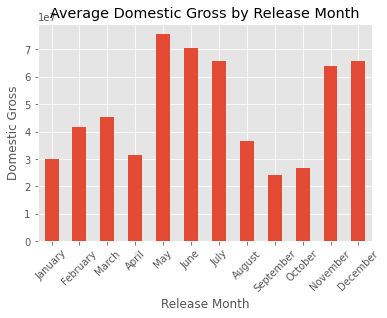

In [65]:
# Visualizing monthly data against domestic gross
tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().sort_index(ascending=True).plot.bar()
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic Gross')
plt.xticks(rotation=45)
plt.style.use('ggplot');

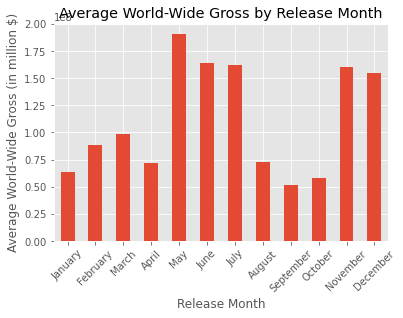

In [66]:
# Visualizing monthly data against worldwide gross
tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().plot.bar()
plt.title('Average World-Wide Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average World-Wide Gross (in million $)')
plt.xticks(rotation=45)
plt.style.use('ggplot');


In [67]:
Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', "October", 'November', 'December']

'''
def get_monthly_data(dataframe):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthly_data = {}
    
    for month in months:
        monthly_data[month] = dataframe[dataframe['release_month'] == month]['worldwide_gross']
    
    return monthly_data
'''
    

# getting monthly data
january = tn_movie_budgets[tn_movie_budgets['release_month'] == 'January']['worldwide_gross']
february = tn_movie_budgets[tn_movie_budgets['release_month'] == 'February']['worldwide_gross']
march = tn_movie_budgets[tn_movie_budgets['release_month'] == 'March']['worldwide_gross']
april = tn_movie_budgets[tn_movie_budgets['release_month'] == 'April']['worldwide_gross']
may = tn_movie_budgets[tn_movie_budgets['release_month'] == 'May']['worldwide_gross']
june = tn_movie_budgets[tn_movie_budgets['release_month'] == 'June']['worldwide_gross']
july = tn_movie_budgets[tn_movie_budgets['release_month'] == 'July']['worldwide_gross']
august = tn_movie_budgets[tn_movie_budgets['release_month'] == 'August']['worldwide_gross']
september = tn_movie_budgets[tn_movie_budgets['release_month'] == 'September']['worldwide_gross']
october = tn_movie_budgets[tn_movie_budgets['release_month'] == 'October']['worldwide_gross']
november = tn_movie_budgets[tn_movie_budgets['release_month'] == 'November']['worldwide_gross']
december = tn_movie_budgets[tn_movie_budgets['release_month'] == 'December']['worldwide_gross']

# Perform the ANOVA test
fvalue, pvalue = stats.f_oneway(january, february, march, april, may, june, july, august, september, october, november, december)

# Print the results
print("F-value:", fvalue)
print("p-value:", pvalue)


F-value: 22.89782281951194
p-value: 4.423783582271991e-46


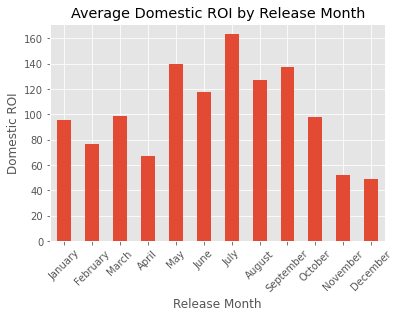

In [68]:
# Visualizing monthly data against ROI
tn_movie_budgets.groupby('release_month')['domestic_ROI'].mean().sort_index(ascending=True).plot.bar()
plt.title('Average Domestic ROI by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic ROI')
plt.xticks(rotation=45)
plt.style.use('ggplot');

In [69]:


# Get the data for each release month
january = tn_movie_budgets[tn_movie_budgets['release_month'] == 'January']['domestic_ROI']
february = tn_movie_budgets[tn_movie_budgets['release_month'] == 'February']['domestic_ROI']
march = tn_movie_budgets[tn_movie_budgets['release_month'] == 'March']['domestic_ROI']
april = tn_movie_budgets[tn_movie_budgets['release_month'] == 'April']['domestic_ROI']
may = tn_movie_budgets[tn_movie_budgets['release_month'] == 'May']['domestic_ROI']
june = tn_movie_budgets[tn_movie_budgets['release_month'] == 'June']['domestic_ROI']
july = tn_movie_budgets[tn_movie_budgets['release_month'] == 'July']['domestic_ROI']
august = tn_movie_budgets[tn_movie_budgets['release_month'] == 'August']['domestic_ROI']
september = tn_movie_budgets[tn_movie_budgets['release_month'] == 'September']['domestic_ROI']
october = tn_movie_budgets[tn_movie_budgets['release_month'] == 'October']['domestic_ROI']
november = tn_movie_budgets[tn_movie_budgets['release_month'] == 'November']['domestic_ROI']
december = tn_movie_budgets[tn_movie_budgets['release_month'] == 'December']['domestic_ROI']

# Perform the ANOVA test
fvalue, pvalue = stats.f_oneway(january, february, march, april, may, june, july, august, september, october, november, december)

# Print the results
print("F-value:", fvalue)
print("p-value:", pvalue)


F-value: 0.6811605829016146
p-value: 0.7577649907029964


Conclusion: 
* Month matters
* Summer and lead up to Oscars
* Spring break bump more visible in ROI
* ANOVA for gross reveals statistically significant difference
* ANOVA for ROI??

## (4.ii) 3-D vs. 2-D Analysis

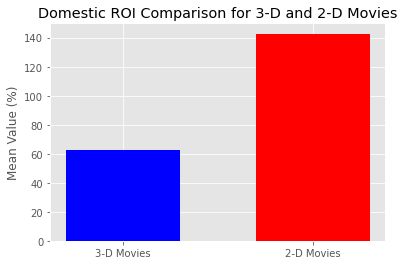

In [76]:
#Creating a Group Bar Chart Comparing the domestic ROIs

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['domestic_ROI'].mean(), no_threed_budgets_df['domestic_ROI'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Domestic ROI Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value (%)')
plt.show()

<ipython-input-75-559242532c40>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000'])
No handles with labels found to put in legend.


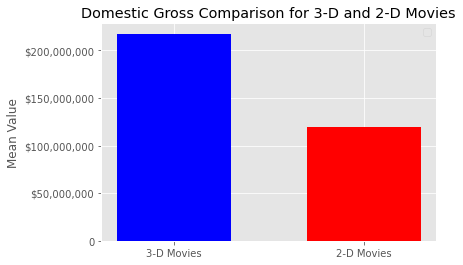

In [75]:
#Creating a Bar Chart Comparing the Domestic Gross Revenues

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['domestic_gross'].mean(), no_threed_budgets_df['domestic_gross'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Domestic Gross Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000'])
plt.legend()
plt.show()

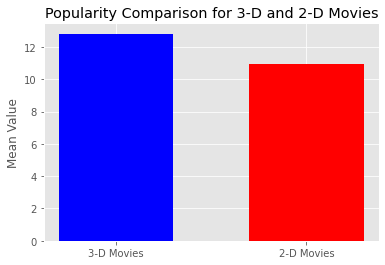

In [74]:
#Creating a Bar Chart Comparing the Popularity Metrics 

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['popularity'].mean(), no_threed_budgets_df['popularity'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Popularity Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.show()

<ipython-input-77-45a1336e0e8f>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000', '$300,000,000'])
No handles with labels found to put in legend.


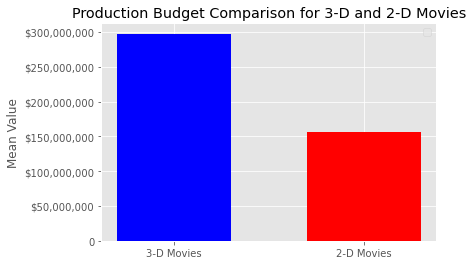

In [77]:
#Creating a Bar Chart Comparing the Production Budgets

x = ['3-D Movies', '2-D Movies']
threed_mean, twod_mean = threed_budgets_df['production_budget'].mean(), no_threed_budgets_df['production_budget'].mean()
plt.bar(x[0], threed_mean, width = 0.6, color='blue')
plt.bar(x[1], twod_mean, width = 0.6, color='red')
plt.title("Production Budget Comparison for 3-D and 2-D Movies")
plt.ylabel('Mean Value')
plt.gca().set_yticklabels(['0', '$50,000,000', '$100,000,000', '$150,000,000', '$200,000,000', '$250,000,000', '$300,000,000'])
plt.legend()
plt.show()

Conclusion: Do i need a conclusion here? Sort of explain this in the Conclusion after the 2-Sample Independent T-tests

### (4.ii.a) 2-Sample Independent T-Tests on 2-D vs. 3-D Movies

#### Using a significance level of $\alpha$ = 0.05

In [ ]:
# Defining a ttest function

def ind_ttest(x, y):
    result = stats.ttest_ind(x, y, equal_var=False)
    return result

#### T-test for Domestic ROI:


Null Hypothesis:  𝐻0
 : 3-D Movies do not have different domestic ROIs than 2-D movies

Alternative Hypothesis:  𝐻𝑎
 : 3-D Movies have different domestic ROIs than 2-D movies

In [ ]:
#T test for 'domestic ROI'
ind_ttest(threed_budgets_df['domestic_ROI'], no_threed_budgets_df['domestic_ROI'])

#### T-test for Domestic Gross:

Null Hypothesis: 𝐻0 : 3-D Movies do not have different domestic gross revenues than 2-D movies

Alternative Hypothesis: 𝐻𝑎 : 3-D Movies have different domestic gross revenues than 2-D movies

In [ ]:
#T test for 'domestic gross'
ind_ttest(threed_budgets_df['domestic_gross'], no_threed_budgets_df['domestic_gross'])

#### T-test for Popularity:

Null Hypothesis: 𝐻0 : 3-D Movies do not have different popularity values than 2-D movies

Alternative Hypothesis: 𝐻𝑎 : 3-D Movies have different popularity values than 2-D movies

In [ ]:
#T test for 'popularity'
ind_ttest(threed_budgets_df['popularity'], no_threed_budgets_df['popularity'])

### We fail to reject the null hypothesis for all three t-tests above because the p-value is less than the  𝛼 level in all three.

Conclusion: 
- 3-D movies would probably not be worth pursuing for a new studio, 
- We found no significance difference between 3-D movies and 2-D movies when comparing based on domestic ROI, domestic gross, and a popularity rating. 
-Furthermore, it is unlikely that a new studio would have a large enough budget to finance a 3-D movie, and even if it did, the fact that the 3-D movies in our sample produced a lower ROI than the 2-D movies is enough to say that it would it might not be the best option. 
-As for the popularity rating, the 3-D movies do have a slighty higher mean, but we would expect that is explained by a correlation between production budget and marketing budget, as the 3-D movies in our sample have almost double the average production budget as the 2-D movies.

## (4.iii) Experienced vs. Inexperienced Directors and Writers Analysis

### Directors Hypothesis Test

In [ ]:
merged_d_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631 entries, 0 to 630
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   averagerating      631 non-null    float64       
 1   numvotes           631 non-null    int64         
 2   person_id          631 non-null    object        
 3   primary_title      631 non-null    object        
 4   Unnamed: 0         631 non-null    int64         
 5   id_x               631 non-null    int64         
 6   popularity         631 non-null    float64       
 7   release_date_x     631 non-null    object        
 8   vote_average       631 non-null    float64       
 9   vote_count         631 non-null    int64         
 10  id_y               631 non-null    int64         
 11  release_date_y     631 non-null    datetime64[ns]
 12  production_budget  631 non-null    int64         
 13  domestic_gross     631 non-null    int64         
 14  worldwide_

In [ ]:
# Defining the variables for the ttests of directors

dx = merged_d_e['averagerating']
dx1 = merged_d_e['popularity']
dx2 = merged_d_e['vote_average']
dx3 = merged_d_e['domestic_gross'].values.astype(int)
dx4 = merged_d_e['worldwide_gross'].values.astype(int)

dy = merged_d_n_e['averagerating']
dy1 = merged_d_n_e['popularity']
dy2 = merged_d_n_e['vote_average']
dy3 = merged_d_n_e['domestic_gross'].values.astype(int)
dy4 = merged_d_n_e['worldwide_gross'].values.astype(int)


In [ ]:
# Director experience level vs. averagerating
ind_ttest(dx, dy)

Ttest_indResult(statistic=1.2132924504712497, pvalue=0.2252211506898824)

In [ ]:
# director experience level vs. popularity
ind_ttest(dx1, dy1)

Ttest_indResult(statistic=10.192747830304803, pvalue=1.931665680763248e-23)

In [ ]:
# director experience level vs. domestic_gross
ind_ttest(dx3, dy3)

Ttest_indResult(statistic=7.44948791804604, pvalue=2.0095027935045344e-13)

In [ ]:
# director experience level vs. worldwide_gross
ind_ttest(dx4, dy4)

Ttest_indResult(statistic=7.865624147495011, pvalue=1.0110746614396123e-14)

Conclusion:

### Writers Hypothesis Test

In [ ]:
# defining the variables for the ttest of writers

wx = merged_w_e['averagerating']
wx1 = merged_w_e['popularity']
wx2 = merged_w_e['vote_average']
wx3 = merged_w_e['domestic_gross'].values.astype(int)
wx4 = merged_w_e['worldwide_gross'].values.astype(int)

wy = merged_w_n_e['averagerating']
wy1 = merged_w_n_e['popularity']
wy2 = merged_w_n_e['vote_average']
wy3 = merged_w_n_e['domestic_gross'].values.astype(int)
wy4 = merged_w_n_e['worldwide_gross'].values.astype(int)


In [ ]:
# writer experience level vs. popularity
ind_ttest(wx1, wy1)

In [ ]:
# writer experience level vs. domestic_gross
ind_ttest(wx3, wy3)

Conclusion:

## (4.iv) Runtime and Budget Analysis

In [ ]:
# defining the variables for runtime and budget tests

x = sm.add_constant(movie_basics_budget['runtime_minutes'])
x1 = sm.add_constant(movie_basics_budget['production_budget'])
y = movie_basics_budget['worldwide_gross']
y1 = movie_basics_budget['popularity']
y2 = movie_basics_budget['vote_average']
y3 = movie_basics_budget['domestic_gross']


In [ ]:
# Defining a linear regression function

def lin_reg(y, x):
    lin_reg_model = sm.OLS(y, x).fit().summary()
    return lin_reg_model

### Budget Regressions and Visuals

In [ ]:
# budget vs. popularity
lin_reg(y1, x1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     702.1
Date:                Wed, 06 Dec 2023   Prob (F-statistic):          4.42e-140
Time:                        17:06:55   Log-Likelihood:                -11024.
No. Observations:                3213   AIC:                         2.205e+04
Df Residuals:                    3211   BIC:                         2.206e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.5075      0.168     38.842      0.000       6.179       6.836
production_budget  6.685e-08   2.52e-09     26.497      0.000    6.19e-08    7.18e-08
==============================================================================
Omnibus:                      672.975   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3237.492
Skew:                           0.923   Prob(JB):                         0.00
Kurtosis:                       7.558   Cond. No.                     8.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# budget vs. popularity scatter
best_line(x1['production_budget'], y1)

In [ ]:
# budget vs. domestic gross
lin_reg(y3, x1)

In [ ]:
# budget vs. domestic gross scatter
best_line(x1['production_budget'], y3)

Conclusion:

### Runtime Regressions and Visuals

In [ ]:
# runtime vs. popularity regression
lin_reg(y1, x)

In [ ]:
# runtime vs. popularity scatter
best_line(x['runtime_minutes'], y1)

In [ ]:
# runtime vs. domestic gross regression
lin_reg(y3, x)

In [ ]:
# runtime vs. domestic gross scatter
best_line(x['runtime_minutes'], y3)

Conclusion:

# Conclusion

## Summation of Recommendations 

Release Month Recommendation:
    
3-D vs. 2-D Movies

Experienced Directors and Writers:

Runtime Recommendation:

Budget Recommendation:

## Limitations

## Next Steps